In [ ]:
!apt-get install -y libgl1-mesa-dev libgl1-mesa-glx libglew-dev libosmesa6-dev software-properties-common patchelf
!pip install gym
!pip install free-mujoco-py==2.1.4

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
libgl1-mesa-dev set to manually installed.
software-properties-common is already the newest version (0.96.24.32.18).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
Suggested packages:
  glew-utils
The following NEW packages will be installed:
  libgl1-mesa-glx libglew-dev libglew2.0 libosmesa6 libosmesa6-dev patchelf
0 upgraded, 6 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,963 kB of archives.
After this operation, 12.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgl1-mesa-glx amd64 20.0.8-0ubuntu1~18.04.1 [5,532 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libglew2.0 amd64 2.0.0-5 [140 kB]
Get:3 http://archive.ubuntu.com/ubuntu bi

In [ ]:
import mujoco_py
import gym
import time
import torch
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt
import string
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optimizer
from torch.distributions import Normal
from matplotlib import pyplot as plt
from tqdm import tqdm
from copy import deepcopy
from torch.optim import Adam
import numpy as np
import copy
import pandas as pd
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

Compiling /usr/local/lib/python3.7/dist-packages/mujoco_py/cymj.pyx because it changed.
[1/1] Cythonizing /usr/local/lib/python3.7/dist-packages/mujoco_py/cymj.pyx
running build_ext
building 'mujoco_py.cymj' extension
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7/usr
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7/usr/local
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuextensionbuilder/temp.linux-x86_64-3.7/usr/local/lib
creating /usr/local/lib/python3.7/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_37_linuxcpuexten

device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
class ReplayBuffer(object):
    def __init__(self, state_dimension, action_dimension, max_size=int(1e6)):
        self.max_size = max_size
        self.counter = 0
        self.size = 0
        self.storage = [np.zeros((max_size, state_dimension)), np.zeros((max_size, action_dimension)), np.zeros((max_size, 1)), np.zeros((max_size, state_dimension)), np.zeros((max_size, 1))]

    def add(self, state, action, reward, next_state, not_done):
        self.storage[0][self.counter] = state
        self.storage[1][self.counter] = action
        self.storage[2][self.counter] = reward
        self.storage[3][self.counter] = next_state
        self.storage[4][self.counter] = not_done
        self.counter = (self.counter + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)
        return (
            torch.FloatTensor(self.storage[0][ind]).to(device),
            torch.FloatTensor(self.storage[1][ind]).to(device),
            torch.FloatTensor(self.storage[2][ind]).to(device),
            torch.FloatTensor(self.storage[3][ind]).to(device),
            torch.FloatTensor(self.storage[4][ind]).to(device)
        )

    def add2file(self, state, action, reward, next_state, not_done):
        with open('/content/gdrive/My Drive/state.csv', 'a') as f_st:
            f_st.write(','.join([str(el) for el in state]))
            f_st.write('\n')
        with open('/content/gdrive/My Drive/action.csv', 'a') as f_a:
            f_a.write(','.join([str(el) for el in action]))
            f_a.write('\n')
        with open('/content/gdrive/My Drive/reward.csv', 'a') as f_r:
            f_r.write(str(reward))
            f_r.write('\n')
        with open('/content/gdrive/My Drive/next_state.csv', 'a') as f_ns:
            f_ns.write(','.join([str(el) for el in next_state]))
            f_ns.write('\n')
        with open('/content/gdrive/My Drive/not_done.csv', 'a') as f_nd:
            f_nd.write(str(not_done))
            f_nd.write('\n')

    def buffer_load(self):
        state = np.array(pd.read_csv('/content/gdrive/My Drive/state.csv'))
        action = np.array(pd.read_csv('/content/gdrive/My Drive/action.csv'))
        reward = np.array(pd.read_csv('/content/gdrive/My Drive/reward.csv'))
        next_state = np.array(pd.read_csv('/content/gdrive/My Drive/next_state.csv'))
        not_done = np.array(pd.read_csv('/content/gdrive/My Drive/not_done.csv'))
        self.size = len(reward)
        self.storage[0][:self.size] = state
        self.storage[1][:self.size] = action
        self.storage[2][:self.size] = reward
        self.storage[3][:self.size] = next_state
        self.storage[4][:self.size] = not_done
        self.counter = (self.counter + 1) % self.max_size

In [ ]:
class Actor(torch.nn.Module):
    def __init__(self, state_dim, n_actions, max_action):
        super(Actor, self).__init__()
        self.max_action = max_action
        self.layer = nn.Sequential(
            nn.Linear(state_dim, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, n_actions),
            nn.Tanh()
        )
    def forward(self, state):
        return self.max_action * self.layer(state)

class Critic(torch.nn.Module):
    def __init__(self, state_dim, n_actions):
        super(Critic, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(state_dim + n_actions, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 1)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(state_dim + n_actions, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, state, action):
        out1 = self.layer1(torch.cat([state, action], 1))
        out2 = self.layer2(torch.cat([state, action], 1))
        return out1, out2
    
    def q1(self, state, action):
        out = self.layer1(torch.cat([state, action], 1))
        return out

In [ ]:
import gym

def evaluate(agent, eval_env, episodes=10):
    reward = 0
    t_max = 10000
    for i in range(episodes):
        state = eval_env.reset()
        is_done = False
        for _ in range(t_max):
            action = agent.select_action(np.array(state))
            state, curr_reward, is_done, _ = eval_env.step(action)
            reward += curr_reward
            if is_done:
                break
    return reward / episodes

In [ ]:
class DDPG(object):
    def __init__(self, state_dim, n_actions, max_action, gamma=0.99, tau=0.005, noise=0.2, noise_max=0.5, update_period=4, lr_actor=3e-4, lr_critic=3e-4):
        self.actor = Actor(state_dim, n_actions, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic = Critic(state_dim, n_actions).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.max_action = max_action
        self.gamma = gamma
        self.tau = tau
        self.noise = noise
        self.noise_max = noise_max
        self.update_period = update_period
        self.iter = 0

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    @staticmethod
    def soft_update(local_model, target_model, tau):
        for param, target_param in zip(local_model.parameters(), target_model.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    def train_update(self, memory, batch_size=64):
        self.iter += 1
        state, action, reward, next_state, not_done = memory.sample(batch_size)
        with torch.no_grad():
            curr_noise = (torch.randn_like(action) * self.noise).clamp(-self.noise_max, self.noise_max)
            next_action = (self.actor_target(next_state) + curr_noise).clamp(-self.max_action, self.max_action)
            target_q1, target_q2 = self.critic_target(next_state, next_action)
            target_q = torch.min(target_q1, target_q2)
            target_q = reward + not_done * self.gamma * target_q

        current_q1, current_q2 = self.critic(state, action)
        critic_loss = func.mse_loss(current_q1, target_q) + func.mse_loss(current_q2, target_q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        policy = self.actor(state)
        q1 = self.critic.q1(state, policy).mean()
        actor_loss = -q1.mean() + batch_size * func.mse_loss(state[:, 0], 1.3 * torch.ones_like(state[:, 0])).mean()
        actor_loss.backward()
        if self.iter % self.update_period == 0:
            
            self.actor_optimizer.step()
            self.actor_optimizer.zero_grad()
            DDPG.soft_update(self.critic, self.critic_target, self.tau)
            DDPG.soft_update(self.actor, self.actor_target, self.tau)

    def save(self):
        torch.save(self.critic.state_dict(), "model_critic.pth")
        torch.save(self.critic_optimizer.state_dict(), "model_critic_optimizer.pth")
        
        torch.save(self.actor.state_dict(), "model_actor.pth")
        torch.save(self.actor_optimizer.state_dict(), "model_actor_optimizer.pth")


    def load(self, curr_device):
        if curr_device == 'cpu':
            self.critic.load_state_dict(torch.load("model_critic.pth", map_location=torch.device('cpu')))
            self.critic_optimizer.load_state_dict(torch.load("model_critic_optimizer.pth", map_location=torch.device('cpu')))
            self.critic_target = copy.deepcopy(self.critic)
            self.actor.load_state_dict(torch.load("model_actor.pth", map_location=torch.device('cpu')))
            self.actor_optimizer.load_state_dict(torch.load("model_actor_optimizer.pth", map_location=torch.device('cpu')))
            self.actor_target = copy.deepcopy(self.actor)
        else:
            self.critic.load_state_dict(torch.load("model_critic.pth"))
            self.critic_optimizer.load_state_dict(torch.load("model_critic_optimizer.pth"))
            self.critic_target = copy.deepcopy(self.critic)

            self.actor.load_state_dict(torch.load("model_actor.pth"))
            self.actor_optimizer.load_state_dict(torch.load("model_actor_optimizer.pth"))
            self.actor_target = copy.deepcopy(self.actor)

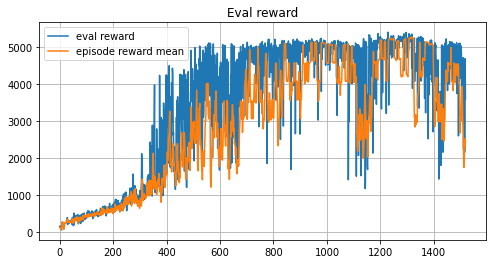

KeyboardInterrupt: ignored

In [7]:
from IPython.display import clear_output

env_name = 'Humanoid-v2'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]
scale = float(env.action_space.high[0])
eval_reward = 0
reward_max = 500
batch_size = 64
agent = DDPG(state_dim=state_dim, n_actions=n_actions, max_action=scale, gamma=0.99, tau=0.005)
#agent.load
#agent.load('cpu')
evaluations = []
memory = ReplayBuffer(state_dim, n_actions)
#memory.buffer_load()
state = env.reset()
is_done = False
episode_reward = 0
episode_timesteps = 0
episode_num = 0
evaluations = []
episode_rewards = []
noise = 0.1
time_start = 5000
episode_rewards_mean = []
for t in range(5000000):
    episode_timesteps += 1
    if t < time_start:
        action = env.action_space.sample()
    else:
        action = (agent.select_action(np.array(state)) + scale * noise * np.random.randn(n_actions)).clip(-scale, scale)     
    next_state, reward, is_done, _ = env.step(action)
    if episode_timesteps < env._max_episode_steps:
        not_done = 1 - is_done
    else:
        not_done = 0
    memory.add(state, action, reward, next_state, not_done)
    #memory.add2file(state, action, reward, next_state, not_done)
    state = next_state
    episode_reward += reward
    if t >= time_start:
        agent.train_update(memory)
    if is_done:
        episode_rewards.append(episode_reward)
        state = env.reset()
        is_done = False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1
    if t % 1000 == 0:
        episode_rewards_mean.append(np.array(episode_rewards[-10:]).mean())
        eval_reward = evaluate(agent, env)
        evaluations.append(eval_reward)
        fig = plt.figure(figsize=[8, 4])
        plt.title("Eval reward")
        clear_output(True)
        plt.plot(evaluations, label='eval reward')
        plt.plot(episode_rewards_mean, label='episode reward mean')
        plt.legend()
        plt.grid()
        plt.show()
        if eval_reward >= reward_max:
            reward_max = eval_reward
            print('eval_reward_max updated!', reward_max)
            agent.save()

In [8]:
import sys, os
from gym.wrappers import Monitor
monitor_env = Monitor(gym.make(env_name), './video/', force=True)
evaluate(agent, monitor_env, episodes=10)
monitor_env.close()
from IPython.display import HTML

video_names = list(filter(lambda s: s.endswith(".mp4"), os.listdir("./video/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./video/"+video_names[-1]))